In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


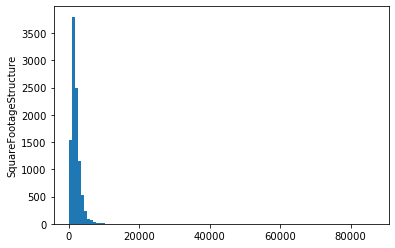

In [2]:
data = pd.read_excel("resd_data.xlsx")
data = data.drop(columns='field_PostalCode')
data.fillna(0, inplace=True)
plt.hist(data.SquareFootageStructure, bins = 100)
plt.ylabel('SquareFootageStructure');

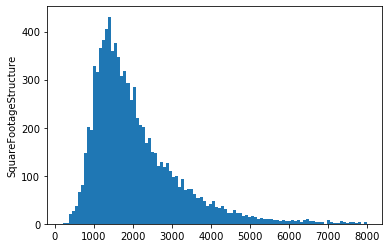

In [3]:
data = data.drop(data[(data.SquareFootageStructure > 8000) | (data.SquareFootageStructure < 100)].index)
plt.hist(data.SquareFootageStructure, bins = 100)
plt.ylabel('SquareFootageStructure');

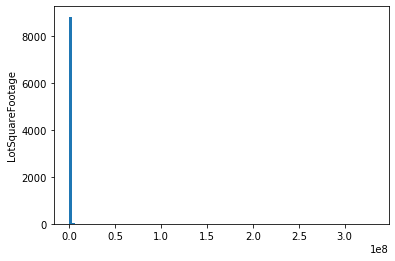

In [4]:
plt.hist(data.LotSquareFootage, bins = 100)
plt.ylabel('LotSquareFootage');

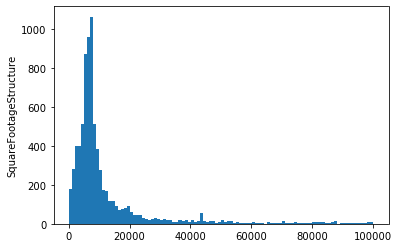

In [5]:
data = data.drop(data[(data.LotSquareFootage > 100000) | (data.LotSquareFootage < 100)].index)
plt.hist(data.LotSquareFootage, bins = 100)
plt.ylabel('SquareFootageStructure');

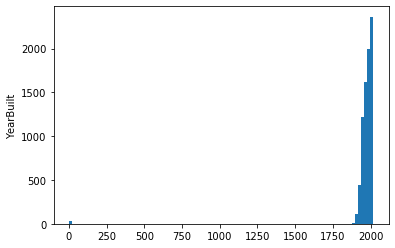

In [6]:
plt.hist(data.YearBuilt, bins = 100)
plt.ylabel('YearBuilt');

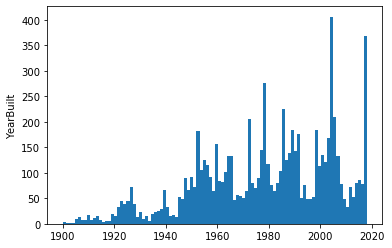

In [7]:
data = data.drop(data[(data.YearBuilt < 1900)].index)
plt.hist(data.YearBuilt, bins = 100)
plt.ylabel('YearBuilt');

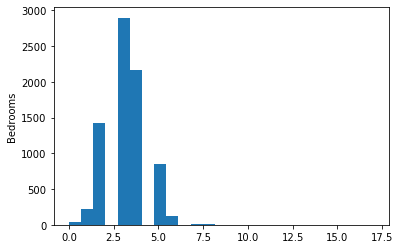

In [8]:
plt.hist(data.Bedrooms, bins = 25)
plt.ylabel('Bedrooms');

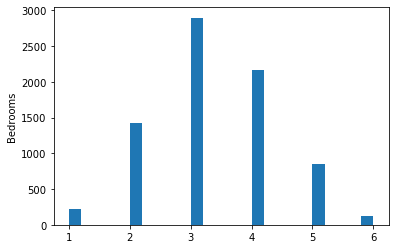

In [9]:
data = data.drop(data[(data.Bedrooms > 6) | (data.Bedrooms < 1)].index)
plt.hist(data.Bedrooms, bins = 25)
plt.ylabel('Bedrooms');

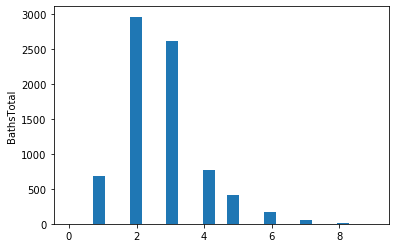

In [10]:
plt.hist(data.BathsTotal, bins = 25)
plt.ylabel('BathsTotal');

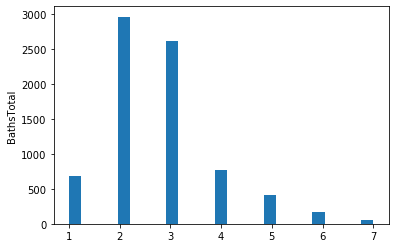

In [11]:
data = data.drop(data[(data.BathsTotal < 1) | (data.BathsTotal > 7)].index)
plt.hist(data.BathsTotal, bins = 25)
plt.ylabel('BathsTotal');

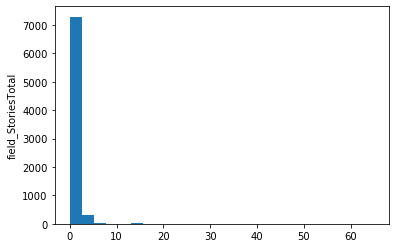

In [12]:
plt.hist(data.field_StoriesTotal, bins = 25)
plt.ylabel('field_StoriesTotal');

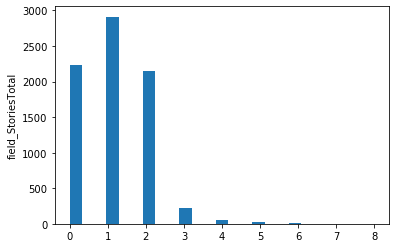

In [13]:
data = data.drop(data[(data.field_StoriesTotal > 8)].index)
plt.hist(data.field_StoriesTotal, bins = 25)
plt.ylabel('field_StoriesTotal');

In [14]:
data = data.to_numpy()
data.shape

(7619, 7)

In [15]:
split = int(0.8*data.shape[0])
train_data, train_targets = data[:split, 0:-1], data[:split, -1]
test_data, test_targets = data[split:, 0:-1], data[split:, -1]

In [16]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [17]:
def build_model():
    
    model = keras.Sequential([
        layers.Dense(128, input_shape=(train_data.shape[1],), activation='relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.RMSprop(0.004), loss='mse', metrics=['mae'])
    #keras.optimizers.RMSprop(0.1)
    return model

In [30]:
k=4
num_val_samples = len(train_data) // k
num_epochs = 300
all_mae_histories = []
all_mae_val_histories = []
all_loss_histories = []
all_loss_val_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=num_epochs, batch_size=2, verbose=0)
    mae_history = history.history['mae']
    mae_val_history = history.history['val_mae']
    loss_history = history.history['loss']
    loss_val_history = history.history['val_loss']
    all_mae_histories.append(mae_history)
    all_mae_val_histories.append(mae_val_history)
    all_loss_histories.append(loss_history)
    all_loss_val_histories.append(loss_val_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [31]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_val_history = [np.mean([x[i] for x in all_mae_val_histories]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_loss_val_history = [np.mean([x[i] for x in all_loss_val_histories]) for i in range(num_epochs)]

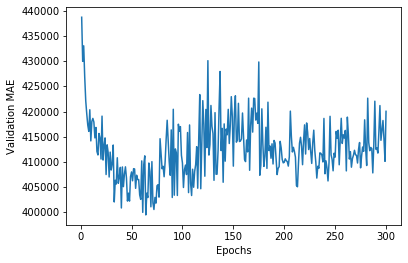

In [32]:
plt.plot(range(1, len(average_mae_val_history) + 1), average_mae_val_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

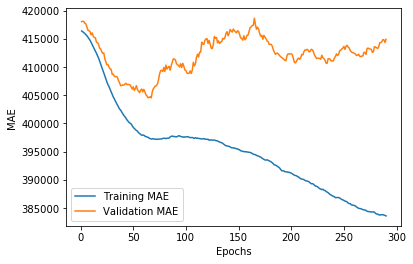

In [33]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history, label = 'Training MAE')
plt.xlabel('Epochs')
smooth_mae_val_history = smooth_curve(average_mae_val_history[10:])
plt.plot(range(1, len(smooth_mae_val_history) + 1), smooth_mae_val_history, label = 'Validation MAE')
plt.ylabel('MAE')
plt.legend()
plt.show()

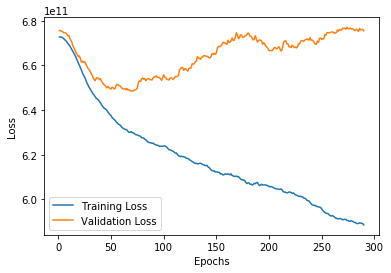

In [34]:
smooth_loss_history = smooth_curve(average_loss_history[10:])
plt.plot(range(1, len(smooth_loss_history) + 1), smooth_loss_history, label = 'Training Loss')
smooth_loss_val_history = smooth_curve(average_loss_val_history[10:])
plt.plot(range(1, len(smooth_loss_val_history) + 1), smooth_loss_val_history, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
num_epoches = 75
model = build_model()
history = model.fit(train_data, train_targets,epochs=num_epoches, batch_size=2, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

1524/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [52]:
test_mae_score

405201.75